# Spot-check EEG classification models based on all features
In this script we spot-check different EEG classification models to clasify different epochs of one subject into resting state, left hand movement and right hand movement using leave one subject out cross-validation, all the features and PCA to reduce the dimensionality of the dataset.

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

## Create some functions

In [2]:
# create a dict of some models to evaluate them {key:model name} {values:model object}
def define_models(models=dict()) :
    models['logistic'] = LogisticRegression()
    models['lda'] = LinearDiscriminantAnalysis()
    models['qda'] = QuadraticDiscriminantAnalysis()
    # non-linear models
    models['cart'] = DecisionTreeClassifier()
    models['knn'] = KNeighborsClassifier()  
    # ensemble models
    models['ada'] = AdaBoostClassifier()
    models['rf'] = RandomForestClassifier()
    models['mlp'] = MLPClassifier()
    models['svcl'] = SVC(kernel='linear',probability=True)
    models['svmp'] = SVC(kernel='poly',probability=True)
    return models

In [3]:
# evaluate a single model with LOSO CV and calculating accuracy, auc of the roc curve and weighted f1
def evaluate_model(X, y, model, subjects_train):
    # evaluate model
    scores = dict()
    scores['accuracy'] = []
    scores['roc_auc'] = []
    scores['f1'] = []
    for subject in subjects_train :
        train_idx = subjects_idx_train != subject
        X_training = X[train_idx.values]
        y_training = y[train_idx.values]
        val_idx = subjects_idx_train == subject
        X_val = X[val_idx.values]
        y_val = y[val_idx.values]
        #train the model
        model.fit(X_training,y_training)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)
        scores['accuracy'].append(accuracy_score(y_val,y_pred))
        scores['roc_auc'].append(roc_auc_score(y_val,y_prob,multi_class='ovo',labels=[0,1,2]))
        scores['f1'].append(f1_score(y_val,y_pred,average='weighted'))
        print(subject)
    print(scores)
    return scores

In [4]:
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, subjects_train):
    results = dict()
    metric='accuracy'
    for name, model in models.items():
        scores = evaluate_model(X, y, model, subjects_train)
        results[name] = scores
        print(name,'evaluated')
    return results

In [5]:
#print and plot the results of the models in order (from the best one to the worse one)
def summarize_results(results):
    # create a list of (name, mean(scores)) tuples
    mean_accuracy_scores = dict()
    mean_auc_scores = dict()
    mean_f1_scores = dict()
    for k,v in results.items() :
        mean_accuracy_scores.update({k : mean(v['accuracy'])})
        mean_auc_scores.update({k : mean(v['roc_auc'])})
        mean_f1_scores.update({k : mean(v['f1'])})
    # sort tuples by mean score
    ordered_accuracy = sorted(mean_accuracy_scores.items(), key=lambda x: x[1])
    # reverse for descending order (from the best one to the worse one)
    ordered_accuracy = list(reversed(ordered_accuracy))
    # retrieve the top for summarization
    names = [x[0] for x in ordered_accuracy]
    accuracy_scores = [results[x]['accuracy'] for x in names]
    auc_scores = [results[x]['roc_auc'] for x in names]
    f1_scores = [results[x]['f1'] for x in names]
    # print the top 
    print()
    for i in range(len(results)):
        name = names[i]
        mean_accuracy_score = mean_accuracy_scores[name]
        mean_auc_score = mean_auc_scores[name]
        mean_f1 = mean_f1_scores[name]
        print('Rank=%d, Name=%s, Accuracy=%.3f, roc_auc=%.3f, f1=%.3f' % (i+1, name, mean_accuracy_score, mean_auc_score, mean_f1))
    # boxplot for the top n
    print(mean_accuracy_score, names)
    plt.figure()
    plt.boxplot(accuracy_scores, labels=names)
    _, labels = pyplot.xticks()
    pyplot.setp(labels, rotation=90)
    plt.title('Accuracy scores')
    plt.figure()
    plt.boxplot(auc_scores, labels=names)
    _, labels = pyplot.xticks()
    pyplot.setp(labels, rotation=90)
    plt.title('ROC-AUC scores')
    plt.figure()
    plt.boxplot(f1_scores, labels=names)
    _, labels = pyplot.xticks()
    pyplot.setp(labels, rotation=90)
    plt.title('F1 scores')

## Read features and labels from all subjects

In [6]:
#read subjects files and merge them
files = os.listdir('Subjects data')
features_all = pd.read_csv('Subjects data/' + files[0], encoding='latin1')
files.pop(0)
for f in files :
    features_subject = pd.read_csv('Subjects data/' + f, encoding='latin1')
    frames = [features_all, features_subject]
    features_all = pd.concat(frames)
#features_all.index = [features_all['Subject'], features_all['Epoch']]
subjects_idx = features_all['Subject'].values
#features_all = features_all.drop(['Subject','Epoch'], axis = 1)
features_all

,Subject,Epoch,Mean_FC5,Variance_FC5,Kurtosis_FC5,Mean_FC3,Variance_FC3,Kurtosis_FC3,Mean_FC1,Variance_FC1,...,PLV_CP1_CP2,PLV_CP1_CP4,PLV_CP1_CP6,PLV_CPz_CP2,PLV_CPz_CP4,PLV_CPz_CP6,PLV_CP2_CP4,PLV_CP2_CP6,PLV_CP4_CP6,Label
0,1,1,0.077105,7.357580,2.809176,0.382332,7.589385,3.297552,0.464633,7.700149,...,0.318132,0.073507,0.323108,0.669452,0.247354,0.067815,0.685624,0.365035,0.772310,1
1,1,2,-0.018304,7.029542,2.842915,0.184697,6.991603,3.060431,0.281971,7.484742,...,0.470648,0.123157,0.181453,0.699222,0.302571,0.062673,0.705291,0.361569,0.726673,2
2,1,3,-0.319861,6.399684,3.428581,-0.346442,6.964995,2.777844,-0.256384,8.132662,...,0.580862,0.386278,0.231118,0.773177,0.498727,0.242550,0.764621,0.475057,0.770152,1
3,1,4,0.036567,8.415375,2.555121,0.150948,9.348971,3.053070,0.207301,8.933164,...,0.607181,0.256862,0.167798,0.806269,0.438541,0.089317,0.747473,0.330642,0.694656,2
4,1,5,0.257114,13.767046,2.879540,0.157239,14.221320,2.764797,-0.017693,13.340810,...,0.464897,0.257998,0.146752,0.819921,0.607017,0.364591,0.854306,0.557560,0.742894,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,44,256,-0.347318,11.215760,2.415819,-0.551029,13.194753,2.405359,-0.656948,12.642553,...,0.080379,0.140109,0.308763,0.595714,0.356431,0.148958,0.845309,0.611503,0.830670,0
256,44,257,0.221785,12.573679,3.445813,0.237528,11.310268,3.638090,0.239306,11.290607,...,0.266919,0.165629,0.418936,0.611298,0.252375,0.062959,0.743924,0.390819,0.758761,0
257,44,258,-0.429369,7.199075,3.063733,-0.496420,8.957319,3.198463,-0.582399,9.467059,...,0.578182,0.322126,0.422456,0.720966,0.303902,0.250078,0.694467,0.191094,0.554233,0
258,44,259,-0.945257,21.763986,6.206397,-0.971078,17.039679,6.818231,-0.958857,15.633321,...,0.444469,0.202010,0.083466,0.758260,0.527970,0.244990,0.844094,0.562038,0.789984,0


## Split the data into training and test

In [7]:
#Select randomly subjects for train and test
subjects = np.unique(subjects_idx)
subjects_train = [15, 12, 21, 4, 10, 44, 3, 18, 29, 20, 7, 19, 11, 2, 28, 5, 8, 16, 6]
subjects_test = [1, 13, 17, 14, 9]
subjects_train, subjects_test

([15, 12, 21, 4, 10, 44, 3, 18, 29, 20, 7, 19, 11, 2, 28, 5, 8, 16, 6],
 [1, 13, 17, 14, 9])

In [8]:
train_idx = features_all['Subject'] == subjects_train[0]
features_train = features_all[train_idx]
subjects_train2 = np.delete(subjects_train, 0, axis=None)
for subject in subjects_train2 :
    train_idx = features_all['Subject'] == subject
    frames = [features_train, features_all[train_idx]]
    features_train = pd.concat(frames)
subjects_idx_train = features_train['Subject']
features_train

,Subject,Epoch,Mean_FC5,Variance_FC5,Kurtosis_FC5,Mean_FC3,Variance_FC3,Kurtosis_FC3,Mean_FC1,Variance_FC1,...,PLV_CP1_CP2,PLV_CP1_CP4,PLV_CP1_CP6,PLV_CPz_CP2,PLV_CPz_CP4,PLV_CPz_CP6,PLV_CP2_CP4,PLV_CP2_CP6,PLV_CP4_CP6,Label
0,15,1,-0.226124,3.195941,2.881555,-0.275889,2.269788,3.280869,-0.109598,2.684536,...,0.498464,0.109177,0.096379,0.723574,0.384581,0.159108,0.645515,0.389479,0.794813,1
1,15,2,0.030149,3.409489,3.228332,0.014870,2.478137,3.812820,-0.002679,1.796357,...,0.266234,0.056251,0.144260,0.655767,0.335991,0.098588,0.706705,0.473348,0.726290,2
2,15,3,0.047237,3.708139,2.910095,-0.005586,2.811760,3.038567,-0.054310,2.949162,...,0.456545,0.202658,0.047853,0.738647,0.387145,0.150339,0.640531,0.420457,0.698610,1
3,15,4,-0.275433,3.773190,2.643662,-0.073327,2.295184,2.892549,0.087973,2.130878,...,0.432633,0.148281,0.160235,0.758073,0.410296,0.160244,0.620352,0.321739,0.709662,1
4,15,5,-0.060434,3.423417,2.893461,-0.089059,2.716601,2.856706,-0.087965,2.550269,...,0.419553,0.095825,0.118061,0.684872,0.278488,0.105448,0.628054,0.470720,0.828787,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,6,273,-0.304880,22.298991,3.302567,-0.129734,14.958487,3.370847,-0.051861,15.985407,...,0.400836,0.100550,0.256252,0.661555,0.268539,0.130888,0.714714,0.310249,0.709654,0
273,6,274,0.269868,33.843053,3.654818,0.212369,16.329158,2.957622,0.039009,16.658380,...,0.552139,0.370040,0.223648,0.712328,0.506982,0.296971,0.870735,0.596865,0.785686,0
274,6,275,0.696642,15.568775,3.843750,0.337532,14.240621,4.116896,0.411972,16.540324,...,0.293143,0.119998,0.265822,0.706523,0.229444,0.090624,0.610597,0.295000,0.726543,0
275,6,276,0.170718,26.607633,2.631762,-0.082792,16.046166,3.065634,-0.065649,16.759860,...,0.383266,0.052075,0.214457,0.670556,0.267428,0.075736,0.681577,0.318358,0.699691,0


In [9]:
features_train.index = [features_train['Subject'], features_train['Epoch']]
X_train = features_train.drop(['Subject','Epoch','Label'], axis = 1)
X_train

Mean_FC5  Variance_FC5  Kurtosis_FC5  Mean_FC3  Variance_FC3  \
Subject Epoch                                                                 
15      1     -0.226124      3.195941      2.881555 -0.275889      2.269788   
        2      0.030149      3.409489      3.228332  0.014870      2.478137   
        3      0.047237      3.708139      2.910095 -0.005586      2.811760   
        4     -0.275433      3.773190      2.643662 -0.073327      2.295184   
        5     -0.060434      3.423417      2.893461 -0.089059      2.716601   
...                 ...           ...           ...       ...           ...   
6       273   -0.304880     22.298991      3.302567 -0.129734     14.958487   
        274    0.269868     33.843053      3.654818  0.212369     16.329158   
        275    0.696642     15.568775      3.843750  0.337532     14.240621   
        276    0.170718     26.607633      2.631762 -0.082792     16.046166   
        277   -0.149774     25.667610      3.001896 -0.331184     15.513927   

               Kurtosis_FC3  Mean_FC1  Variance_FC1  Kurtosis_FC1  Mean_FC2  \
Subject Epoch                                                                 
15      1          3.280869 -0.109598      2.684536      2.901555 -0.101212   
        2          3.812820 -0.002679      1.796357      2.764866  0.045633   
        3          3.038567 -0.054310      2.949162      3.309821 -0.171491   
        4          2.892549  0.087973      2.130878      2.651647  0.310267   
        5          2.856706 -0.087965      2.550269      3.046728 -0.186947   
...                     ...       ...           ...           ...       ...   
6       273        3.370847 -0.051861     15.985407      3.068512 -0.181406   
        274        2.957622  0.039009     16.658380      3.534025 -0.243350   
        275        4.116896  0.411972     16.540324      4.061586  0.370064   
        276        3.065634 -0.065649     16.759860      3.330850 -0.213369   
        277        2.970890 -0.570239     19.720077      3.202597 -0.779327   

               ...  PLV_CP1_CPz  PLV_CP1_CP2  PLV_CP1_CP4  PLV_CP1_CP6  \
Subject Epoch  ...                                                       
15      1      ...     0.610267     0.498464     0.109177     0.096379   
        2      ...     0.519540     0.266234     0.056251     0.144260   
        3      ...     0.601333     0.456545     0.202658     0.047853   
        4      ...     0.605191     0.432633     0.148281     0.160235   
        5      ...     0.610368     0.419553     0.095825     0.118061   
...            ...          ...          ...          ...          ...   
6       273    ...     0.749228     0.400836     0.100550     0.256252   
        274    ...     0.818852     0.552139     0.370040     0.223648   
        275    ...     0.634006     0.293143     0.119998     0.265822   
        276    ...     0.728297     0.383266     0.052075     0.214457   
        277    ...     0.805974     0.530426     0.263476     0.195801   

               PLV_CPz_CP2  PLV_CPz_CP4  PLV_CPz_CP6  PLV_CP2_CP4  \
Subject Epoch                                                       
15      1         0.723574     0.384581     0.159108     0.645515   
        2         0.655767     0.335991     0.098588     0.706705   
        3         0.738647     0.387145     0.150339     0.640531   
        4         0.758073     0.410296     0.160244     0.620352   
        5         0.684872     0.278488     0.105448     0.628054   
...                    ...          ...          ...          ...   
6       273       0.661555     0.268539     0.130888     0.714714   
        274       0.712328     0.506982     0.296971     0.870735   
        275       0.706523     0.229444     0.090624     0.610597   
        276       0.670556     0.267428     0.075736     0.681577   
        277       0.788003     0.473607     0.175662     0.745219   

               PLV_CP2_CP6  PLV_CP4_CP6  
Subject Epoch                            
15      1     

In [10]:
Y_train = features_train['Label']
Counter(Y_train)

Counter({1: 1737, 2: 1701, 0: 1493})

## Spot-check algorithms standardizing data
Preprocess the training features matrix

In [11]:
standardizer = StandardScaler()
X_scaled_train = standardizer.fit_transform(X_train)
X_scaled_train.shape

(4931, 310)

Preprocess the training labels

In [12]:
Counter(Y_train)

Counter({1: 1737, 2: 1701, 0: 1493})

In [13]:
# get model list
models = define_models()

C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


15


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


12


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


21


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


4


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


10


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


44


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


18


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


29


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


20


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


7


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


19


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


11


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


28


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


5


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


8


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


16


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


6
{'accuracy': [0.3470790378006873, 0.40756302521008403, 0.5664335664335665, 0.42700729927007297, 0.3597122302158273, 0.65, 0.38967136150234744, 0.5107142857142857, 0.46842105263157896, 0.6124031007751938, 0.43727598566308246, 0.6387434554973822, 0.46825396825396826, 0.5, 0.6053511705685619, 0.5370370370370371, 0.3088235294117647, 0.4524714828897338, 0.5703971119133574], 'roc_auc': [0.648228625499609, 0.5835554925316695, 0.9317317053633047, 0.7463240799363199, 0.684253451967279, 0.8706774628879893, 0.7032052364864866, 0.730061501344724, 0.6690917107583774, 0.789014792629756, 0.6823361132359436, 0.7372989766081871, 0.7710553060354718, 0.7912824282615949, 0.8235429292929294, 0.724675925925926, 0.7414738461123328, 0.6648028866225324, 0.7837834803460518], 'f1': [0.23627726492063858, 0.3622984292844814, 0.5094525024327468, 0.3428968874827041, 0.2409782204028237, 0.6143977947413062, 0.3476510365452222, 0.43407115243981087, 0.4636053696995525, 0.6088618227672689, 0.33832881081784527, 0.620719

15


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


12
21
4
10
44
3
18
29
20
7
19
11
2
28
5
8
16
6
{'accuracy': [0.46048109965635736, 0.4579831932773109, 0.5454545454545454, 0.45985401459854014, 0.4064748201438849, 0.6038461538461538, 0.4225352112676056, 0.4857142857142857, 0.5631578947368421, 0.4806201550387597, 0.5089605734767025, 0.5863874345549738, 0.49206349206349204, 0.5807692307692308, 0.5117056856187291, 0.4962962962962963, 0.3125, 0.4600760456273764, 0.5090252707581228], 'roc_auc': [0.6579150134812249, 0.657647948572509, 0.9133219184412895, 0.7255915054743647, 0.708533345428553, 0.7835357624831308, 0.7313522897897897, 0.7163510026103465, 0.7756771227009321, 0.7135162646861203, 0.6863384681720847, 0.7023358585858586, 0.7587829855229783, 0.7913950408742075, 0.7068685185185185, 0.6444647867564534, 0.7089549688114158, 0.6757798055704658, 0.7692419312471932], 'f1': [0.47039514523237663, 0.42615351093997966, 0.4852553936155025, 0.42584950921873777, 0.3226515399468278, 0.5761697285434673, 0.3737927337110934, 0.41709095329170637, 0.556

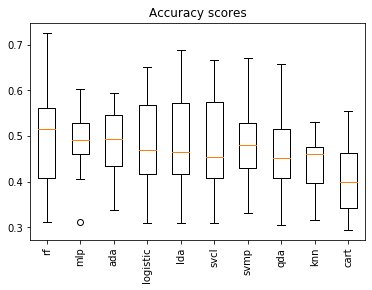

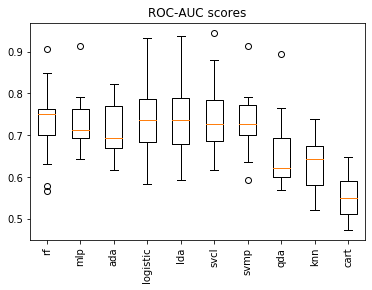

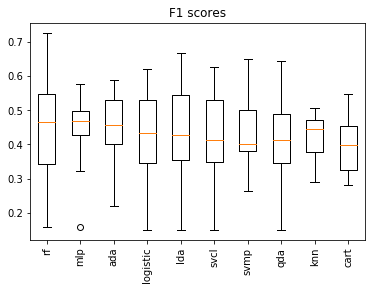

In [14]:
# evaluate models
results = evaluate_models(X_scaled_train, Y_train, models, subjects_train)
# summarize results
summarize_results(results)

## Spot-check algorithms standardizing and normalizing data
Preprocess the training features matrix

In [15]:
X_scaled_train = standardizer.fit_transform(X_train)
normalizer = MinMaxScaler(feature_range=(0,1))
X_scaled_train = normalizer.fit_transform(X_scaled_train)
X_scaled_train.shape

(4931, 310)

C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


15


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


12


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


21


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


4


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


10


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


44


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


18


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


29


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


20


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


7


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


19


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


11


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


28


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


5


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


8


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


16


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


6
{'accuracy': [0.38831615120274915, 0.42857142857142855, 0.6118881118881119, 0.46715328467153283, 0.381294964028777, 0.676923076923077, 0.39906103286384975, 0.5, 0.6210526315789474, 0.6046511627906976, 0.5232974910394266, 0.6178010471204188, 0.48412698412698413, 0.5384615384615384, 0.4782608695652174, 0.5333333333333333, 0.3382352941176471, 0.4372623574144487, 0.5884476534296029], 'roc_auc': [0.6760611441139291, 0.5449430084001837, 0.9497163222172927, 0.7526726003297841, 0.6914698463655125, 0.8710121457489879, 0.7570096659159159, 0.6861326168064125, 0.7886290627362057, 0.7994527214496311, 0.7438159086715963, 0.7292093871041239, 0.7592832398999007, 0.8120808308308307, 0.8181570707070708, 0.6900813692480359, 0.7614507301321748, 0.676244259557464, 0.8002758077226163], 'f1': [0.3293157099317973, 0.35974165730903224, 0.533062824550745, 0.3988745305081143, 0.287680880140608, 0.6408889849462936, 0.3592770816503127, 0.4308226355127645, 0.6306391095924494, 0.5999061677044348, 0.449459491778694

C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


15


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


12


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


21


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


10


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


44


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


18


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


29


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


20


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


19


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


11


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


28


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


8


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


16


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


6
{'accuracy': [0.43986254295532645, 0.39915966386554624, 0.5384615384615384, 0.44525547445255476, 0.3776978417266187, 0.6884615384615385, 0.40375586854460094, 0.5357142857142857, 0.5842105263157895, 0.5581395348837209, 0.4767025089605735, 0.6230366492146597, 0.5158730158730159, 0.3384615384615385, 0.5785953177257525, 0.5296296296296297, 0.30514705882352944, 0.4448669201520912, 0.5631768953068592], 'roc_auc': [0.6960979343402238, 0.5725846095670258, 0.9398272669575077, 0.7654250283941892, 0.6982881064513718, 0.8658960863697706, 0.72887621996997, 0.7486824671729156, 0.8099458301839255, 0.7873948947516792, 0.7122346809952921, 0.7999520581757423, 0.7746675797523256, 0.8453922672672673, 0.8005311447811447, 0.7310030864197531, 0.7189454345939188, 0.7002497465259139, 0.7897724480371471], 'f1': [0.4084120091516975, 0.3334257079211996, 0.4675297389446219, 0.36462069564620697, 0.28427768846149576, 0.6379359770664118, 0.3426538564955272, 0.45451687068911945, 0.5827037415890166, 0.555515929479720

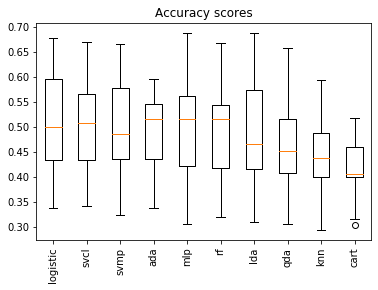

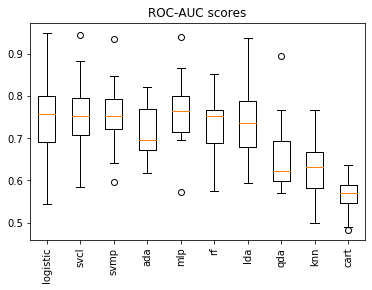

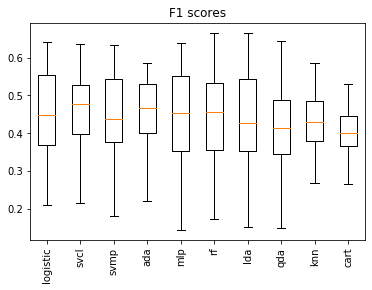

In [16]:
# evaluate models
results = evaluate_models(X_scaled_train, Y_train, models, subjects_train)
# summarize results
summarize_results(results)

## Spot-check reducing dimensionality (PCA) and standardizing the data
Preprocess the training features matrix

In [17]:
standardizer = StandardScaler()
pca = PCA(n_components = 20)
X_scaled_train = pca.fit_transform(X_train)
X_scaled_train = standardizer.fit_transform(X_scaled_train)
X_scaled_train.shape

(4931, 20)

15
12
21
4
10
44
3
18
29
20
7
19
11
2
28
5
8
16
6
{'accuracy': [0.3539518900343643, 0.38235294117647056, 0.7202797202797203, 0.40145985401459855, 0.34172661870503596, 0.6653846153846154, 0.4788732394366197, 0.48928571428571427, 0.5105263157894737, 0.5038759689922481, 0.5448028673835126, 0.612565445026178, 0.43253968253968256, 0.5576923076923077, 0.4682274247491639, 0.43703703703703706, 0.33088235294117646, 0.40304182509505704, 0.5523465703971119], 'roc_auc': [0.658662509042285, 0.6358513626664505, 0.950203881371389, 0.7172680893096862, 0.670744183585275, 0.7262334682860999, 0.7304086899399399, 0.7029029392764858, 0.6582309775762157, 0.725776777330544, 0.7370257736980997, 0.6669265493278651, 0.6853821907013398, 0.7736992200533868, 0.6296279461279461, 0.6144767115600449, 0.7060058824323048, 0.645636021152661, 0.7642638348712474], 'f1': [0.2955444128069098, 0.35970748955319837, 0.6907643710380399, 0.3084969747862972, 0.199582408324183, 0.6194871273818642, 0.4761822322480267, 0.41278388278

C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


15


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


12


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


21


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


10


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


44


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


18


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


29


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


20


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


19


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


11


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


28


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


8


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


16


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


6
{'accuracy': [0.40893470790378006, 0.41596638655462187, 0.43356643356643354, 0.4416058394160584, 0.4028776978417266, 0.6846153846153846, 0.4084507042253521, 0.5035714285714286, 0.6210526315789474, 0.562015503875969, 0.43727598566308246, 0.6596858638743456, 0.4722222222222222, 0.6115384615384616, 0.5183946488294314, 0.4666666666666667, 0.3161764705882353, 0.4790874524714829, 0.5451263537906137], 'roc_auc': [0.6177641625930715, 0.6141756475704292, 0.9112846451986591, 0.7075026336322058, 0.6073297450848472, 0.842085020242915, 0.6200023460960962, 0.713094249327638, 0.8007495590828925, 0.7412058144636692, 0.7575562147718345, 0.7852419875446192, 0.6760230626981438, 0.8223739364364365, 0.7611984848484848, 0.6371513748597081, 0.6311002127209847, 0.6697073616826703, 0.7258015794334715], 'f1': [0.36493611771962287, 0.4043929342630048, 0.35419706026626047, 0.3837414527031178, 0.31067013747450045, 0.6609079430850497, 0.4016370768367776, 0.5089034939701608, 0.6110335287530465, 0.5573927212778103,

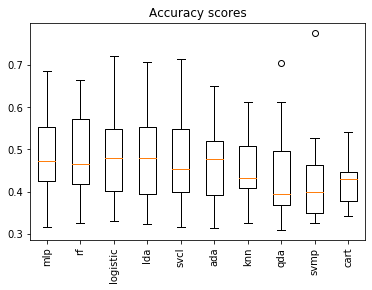

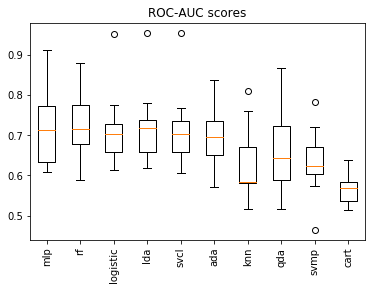

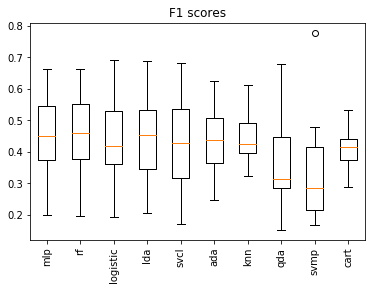

In [18]:
# evaluate models
results = evaluate_models(X_scaled_train, Y_train, models, subjects_train)
# summarize results
summarize_results(results)

## Spot-check reducing dimensionality (PCA), standardizing and normalizing the data
Preprocess the training features matrix

In [19]:
standardizer = StandardScaler()
normalizer = MinMaxScaler(feature_range=(0,1))
X_scaled_train = pca.fit_transform(X_train)
X_scaled_train = standardizer.fit_transform(X_scaled_train)
X_scaled_train = normalizer.fit_transform(X_scaled_train)
X_scaled_train.shape

(4931, 20)

C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


15
12


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


21


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


4


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


10


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


44


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


18


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


29


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


20


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


7
19


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


11


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


28


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


5


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


8


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


16


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


6
{'accuracy': [0.3333333333333333, 0.38235294117647056, 0.7692307692307693, 0.38686131386861317, 0.36330935251798563, 0.6807692307692308, 0.5352112676056338, 0.5071428571428571, 0.5368421052631579, 0.5116279069767442, 0.5555555555555556, 0.5968586387434555, 0.4166666666666667, 0.5653846153846154, 0.4682274247491639, 0.4444444444444444, 0.34558823529411764, 0.41064638783269963, 0.5703971119133574], 'roc_auc': [0.6862962800587474, 0.628398563055398, 0.944297329439022, 0.7320775089123165, 0.6696593935759264, 0.7537503373819163, 0.7968557620120119, 0.7474802905658388, 0.6931831065759638, 0.731466026126086, 0.7491116127788454, 0.6793617566643881, 0.7074786815140223, 0.7943219260927594, 0.6413585858585859, 0.6356460437710437, 0.7176171651893126, 0.6565945508041588, 0.773543430183787], 'f1': [0.2785310934365808, 0.33660739410189944, 0.7618453648877305, 0.2731527275827056, 0.24910942425012655, 0.6331307638999948, 0.5380543485537084, 0.42450911361258625, 0.5400793595544726, 0.5103419719015138,

C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


15


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


12


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


21


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


10


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


44


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


18


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


29


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


20


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


7


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


19


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


11


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


28


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


5


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


8


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


16


C:\Users\Mikel\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


6
{'accuracy': [0.3642611683848797, 0.3403361344537815, 0.7517482517482518, 0.3905109489051095, 0.3489208633093525, 0.6730769230769231, 0.47417840375586856, 0.5321428571428571, 0.5421052631578948, 0.5077519379844961, 0.5555555555555556, 0.675392670157068, 0.4444444444444444, 0.6230769230769231, 0.5150501672240803, 0.43703703703703706, 0.3161764705882353, 0.4714828897338403, 0.5451263537906137], 'roc_auc': [0.6543603907728505, 0.5911291629527592, 0.9497760154786552, 0.7203030056245452, 0.6635989745941592, 0.7324912280701755, 0.7499676238738738, 0.7571990521014608, 0.7191625724363818, 0.7285534423227332, 0.7467036076543717, 0.743443599529126, 0.6865444928914096, 0.8069725975975975, 0.6472407407407407, 0.6376262626262625, 0.7044894021775793, 0.6607033160374546, 0.7629832990162435], 'f1': [0.28778160075486964, 0.274313000206388, 0.7532415289095111, 0.26625746516257465, 0.21930090541606465, 0.633345947433604, 0.4718583806717399, 0.48597238353335914, 0.5425279310808991, 0.4341744974451419, 0

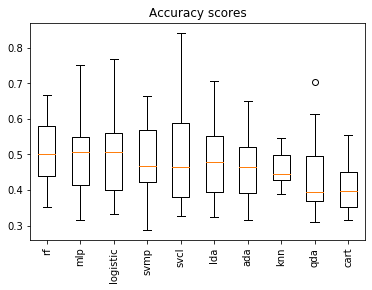

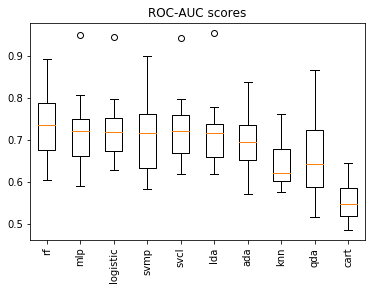

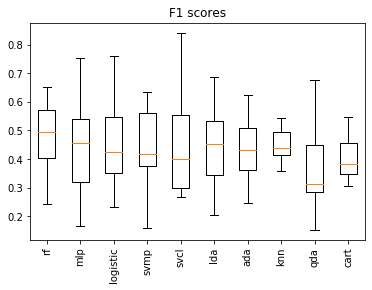

In [20]:
# evaluate models
results = evaluate_models(X_scaled_train, Y_train, models, subjects_train)
# summarize results
summarize_results(results)

Normalizing the data improved a bit the results, but generally PCA will not be useful for this data. 